In [ ]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [ ]:
if(torch.cuda.is_available()):
  device = torch.device("cuda")
  print(device, torch.cuda.get_device_name(0))
else:
  device= torch.device("cpu")
  print(device)

cuda Tesla T4


Load ImageNet pre-trained image classification CNN models

In [ ]:
#vgg = torchvision.models.vgg19(pretrained=True)
#resnet = torvision.models.resnet(pretrained=True)

In [ ]:
alexnet = torchvision.models.alexnet(pretrained=True)
alexnet.eval()
alexnet.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Upload input image from local drive

In [ ]:
from google.colab import files
uploaded = files.upload()
fnameLst = list(uploaded.keys())
fname = fnameLst[0]
print(fname)

Saving cat.jfif to cat (1).jfif
cat.jfif


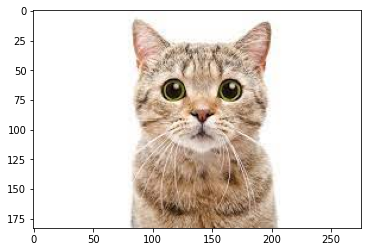

In [ ]:
image = cv2.imread(fname)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [ ]:
#pre-processing
transformer = transforms.Compose([
     transforms.Resize(224),
     transforms.CenterCrop(224),            
     transforms.ToTensor(),                     
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5] )])

PILImg= Image.fromarray(image.astype('uint8')).convert('RGB')
PILImg = transformer(PILImg)
PILImg.shape

imageTensor = torch.unsqueeze(PILImg, 0)
imageTensor = imageTensor.to(device)
imageTensor.shape

torch.Size([1, 3, 224, 224])

#Generate GradCAM for the input img

Reference: https://github.com/vickyliin/gradcam_plus_plus-pytorch

https://pypi.org/project/pytorch-gradcam/

In [ ]:
!pip install pytorch-gradcam

In [ ]:
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

In [ ]:
gradcam = GradCAM.from_config(model_type='alexnet', arch=alexnet, layer_name='features_11')

In [ ]:
#send input image to CNN to get model output
logit = alexnet(imageTensor)
print(logit.shape)

torch.Size([1, 1000])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
#find the class index predicted by the CNN model
class_idx = int(logit.max(1)[-1])
print(class_idx)

285


Find class name: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [ ]:
#285 = Egyptian cat

In [ ]:
# get a GradCAM saliency map on the class index 
mask, logit = gradcam(imageTensor, class_idx=class_idx) 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [ ]:
# make heatmap from mask and synthesize saliency map using heatmap and img
heatmap, cam_result = visualize_cam(mask, imageTensor)

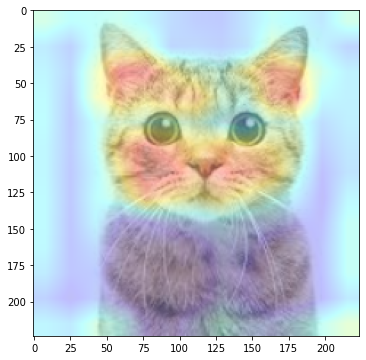

In [ ]:
# Visualize heatmap on input img
fig=plt.figure(figsize=(12, 6))
ImgArray = np.zeros((cam_result.shape[1], cam_result.shape[2], 3))
ImgArray[:,:,0] = cam_result[0, :, :]  
ImgArray[:,:,1] = cam_result[1, :, :]
ImgArray[:,:,2] = cam_result[2, :, :]
ImgArray = ImgArray*0.5+0.5  # convert[-1, 1] to [0, 1]
plt.imshow(ImgArray)
plt.show()

Generate heatmap for dog class

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


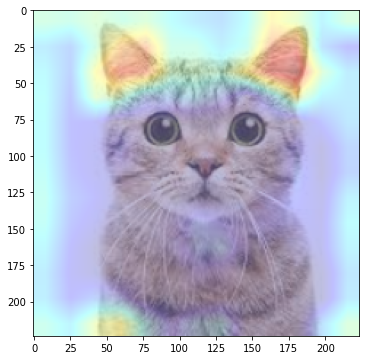

In [ ]:
#Try another class index
class_idx = 278 #'kit fox
mask, logit = gradcam(imageTensor, class_idx=class_idx)
heatmap, cam_result = visualize_cam(mask, imageTensor)

fig=plt.figure(figsize=(12, 6))
ImgArray = np.zeros((cam_result.shape[1], cam_result.shape[2], 3))
ImgArray[:,:,0] = cam_result[0, :, :]  
ImgArray[:,:,1] = cam_result[1, :, :]
ImgArray[:,:,2] = cam_result[2, :, :]
ImgArray = ImgArray*0.5+0.5  # convert[-1, 1] to [0, 1]
plt.imshow(ImgArray)
plt.show()

#Below I implemnt GradCAM step-by-step

Define model and the layer in the model to generate GradCAM 

In [ ]:
#gradcam = GradCAM.from_config(model_type='alexnet', arch=alexnet, layer_name='features_11')
target_layer = alexnet.features[10]
print(target_layer)

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


Initialize hook to memorize gradients

In [ ]:
gradients = dict()
activations = dict()

In [ ]:
def forward_hook(module, input, output):
  activations['value'] = output

def backward_hook(module, grad_input, grad_output):
  gradients['value'] = grad_output[0]

In [ ]:
target_layer.register_forward_hook(forward_hook)

In [ ]:
target_layer.register_backward_hook(backward_hook)

backprocessing output to get gradients

In [ ]:
#mask, logit = gradcam(imageTensor, class_idx=285) 
b, c, h, w = imageTensor.size()
print(b, c, h, w)

1 3 224 224


In [ ]:
#logit: model output
logit = alexnet(imageTensor)
print(logit.shape)

torch.Size([1, 1000])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
class_idx = int(logit.max(1)[-1])
print(class_idx)

285


In [ ]:
logit[:, class_idx]

tensor([15.7888], device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
score = logit[:, class_idx].squeeze()
print(score)

tensor(15.7888, device='cuda:0', grad_fn=<SqueezeBackward0>)


In [ ]:
# Zero grads
alexnet.zero_grad()

In [ ]:
# Backward pass with specified target
score.backward(retain_graph=False)

In [ ]:
# Get hooked gradients
gradients = gradients['value']
print(gradients.shape)

torch.Size([1, 256, 13, 13])


In [ ]:
activations = activations['value']
print(activations.shape)

torch.Size([1, 256, 13, 13])


In [ ]:
b, k, u, v = gradients.size()
print(b, k, u, v)

1 256 13 13


In [ ]:
alpha = gradients.view(b, k, -1).mean(2)
print(alpha.shape)

torch.Size([1, 256])


In [ ]:
weights = alpha.view(b, k, 1, 1)
print(weights.shape)

torch.Size([1, 256, 1, 1])


In [ ]:
saliency_map = (weights*activations).sum(1, keepdim=True)
print(saliency_map.shape)

torch.Size([1, 1, 13, 13])


In [ ]:
saliency_map = F.relu(saliency_map)
print(saliency_map.shape)

torch.Size([1, 1, 13, 13])


In [ ]:
saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
print(saliency_map.shape)

torch.Size([1, 1, 224, 224])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [ ]:
saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data

Visualize_cam(mask, imageTensor)

In [ ]:
heatmap = (255 * saliency_map.squeeze()).type(torch.uint8).cpu().numpy()
print(heatmap.shape)

(224, 224)


In [ ]:
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

In [ ]:
heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
print(heatmap.shape)

torch.Size([3, 224, 224])


In [ ]:
b, g, r = heatmap.split(1)
print(b.shape, g.shape, r.shape)

torch.Size([1, 224, 224]) torch.Size([1, 224, 224]) torch.Size([1, 224, 224])


In [ ]:
alpha=1.0
heatmap = torch.cat([r, g, b]) * alpha

In [ ]:
result = heatmap+imageTensor.cpu()
print(result.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
result = result.div(result.max()).squeeze()
print(result.shape)

torch.Size([3, 224, 224])


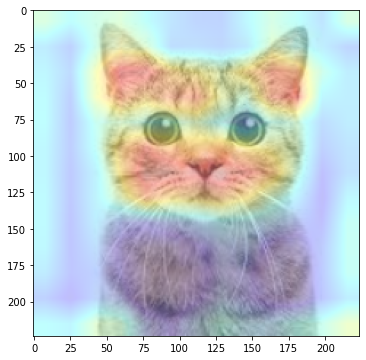

In [ ]:
# Visualize heatmap on input img
fig=plt.figure(figsize=(12, 6))
ImgArray = np.zeros((result.shape[1], cam_result.shape[2], 3))
ImgArray[:,:,0] = result[0, :, :]  
ImgArray[:,:,1] = result[1, :, :]
ImgArray[:,:,2] = result[2, :, :]
ImgArray = ImgArray*0.5+0.5  # convert[-1, 1] to [0, 1]
plt.imshow(ImgArray)
plt.show()